Detected R-peaks (60 seconds): 16
16 16


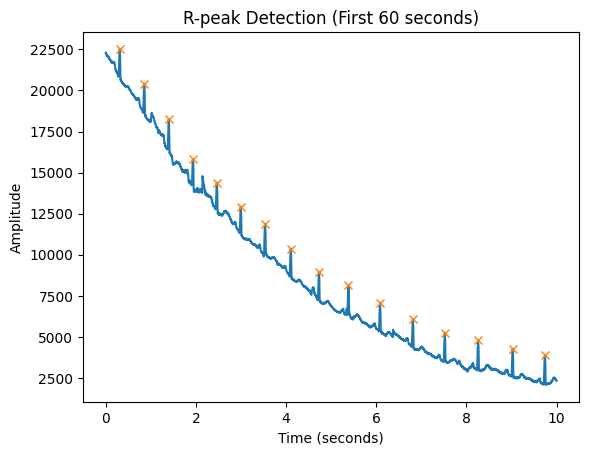

In [57]:
height_threshold = 2000  # Minimální amplituda vrcholu
distance_threshold = 500  # Minimální vzdálenost mezi vrcholy (300 vzorků ~ 0.3s při 1000 Hz)

# Detekce R-vrcholu
peaks_60s, _ = find_peaks(signal_60s, height=height_threshold, distance=distance_threshold)
time_peaks_60s = [time_axis[p] for p in peaks_60s]
print(f"Detected R-peaks (60 seconds): {len(peaks_60s)}")
print(len(time_peaks_60s), len(signal_60s[peaks_60s]))
# Vykreslení výsledků
plt.plot(time_axis, signal_60s)
plt.plot(time_peaks_60s, signal_60s[peaks_60s], "x")
plt.title('R-peak Detection (First 60 seconds)')
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude')
plt.show()

Zpracovávám záznam 1/1: 100001_ECG
Načítám záznam: brno-university-of-technology/100001\100001_ECG
  Doba načtení záznamu: 0.52 s
  Předzpracování signálu...
  Detekce R-píků...
  Počet R-píků: 110317
  Doba detekce R-píků: 0.72 s
  Výpočet RR intervalů...
  Detekce anomálních RR intervalů...
Zpracování záznamu trvalo: 3.69 s
Vytvářím tabulku s výsledky...
Statistiky:
       Record  Anomalies Count  Mean RR Interval Anomalous RR Intervals
0  100001_ECG                0          0.789427                     []


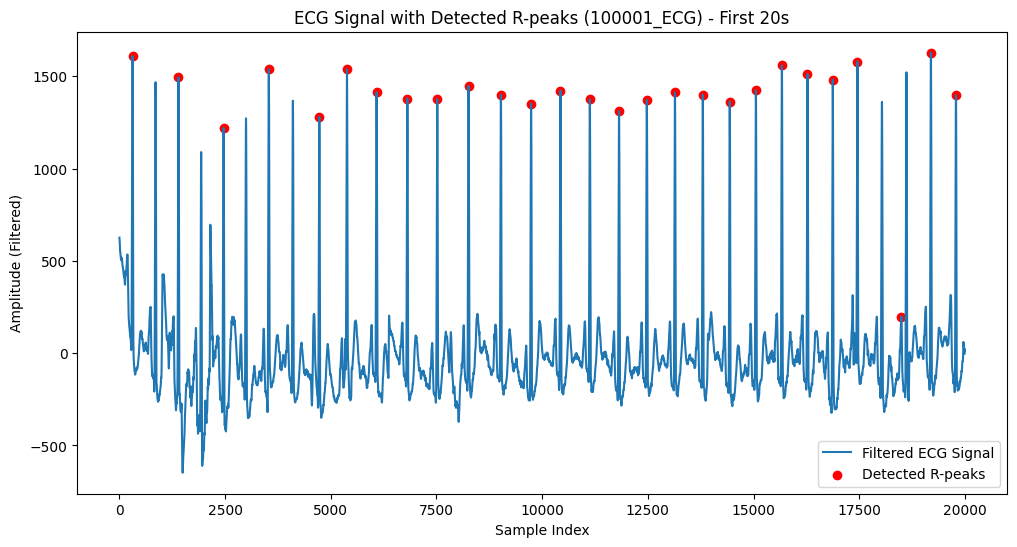

In [25]:
import wfdb
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from scipy.signal import butter, filtfilt, find_peaks
import time  # Pro měření času

# Funkce pro předzpracování signálu (band-pass filtr)
def preprocess_signal(signal, fs):
    lowcut, highcut = 0.5, 45.0
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(1, [low, high], btype="band")
    filtered_signal = filtfilt(b, a, signal)
    return filtered_signal

# Zrychlená detekce R-píků pomocí scipy.find_peaks
def detect_r_peaks(signal, fs):
    distance = int(0.58 * fs)  # Vzdálenost mezi vrcholy (minimální RR interval ~ 0.6 s)
    peaks, _ = find_peaks(signal, distance=distance, height=np.mean(signal))  # Rychlejší detekce
    return peaks

# Funkce pro detekci abnormalit v RR intervalech
def detect_anomalies(rr_intervals, threshold=2.0):
    return rr_intervals[rr_intervals > threshold]

# Funkce pro zpracování jednoho záznamu
def process_record(record_path):
    print(f"Načítám záznam: {record_path}")

    start_time = time.time()  # Měření času načtení
    record = wfdb.rdrecord(record_path)
    signal = record.p_signal[:, 0]
    fs = record.fs
    print(f"  Doba načtení záznamu: {time.time() - start_time:.2f} s")

    print("  Předzpracování signálu...")
    filtered_signal = preprocess_signal(signal, fs)

    print("  Detekce R-píků...")
    start_time = time.time()
    r_peaks = detect_r_peaks(filtered_signal, fs)
    print(f"  Počet R-píků: {len(r_peaks)}")
    print(f"  Doba detekce R-píků: {time.time() - start_time:.2f} s")

    if len(r_peaks) < 2:
        print(f"  Nedostatečný počet R-píků detekován v {record.record_name}")
        return None

    print("  Výpočet RR intervalů...")
    rr_intervals = np.diff(r_peaks) / fs

    print("  Detekce anomálních RR intervalů...")
    anomalous_rr_intervals = detect_anomalies(rr_intervals)

    anomaly_count = len(anomalous_rr_intervals)
    return {
        'Record': record.record_name,
        'Anomalies Count': anomaly_count,
        'Anomalous RR Intervals': anomalous_rr_intervals,
        'RR Intervals': rr_intervals,
        'Filtered Signal': filtered_signal,
        'R Peaks': r_peaks,
        'Fs': fs
    }

# Cesta k adresáři s EKG daty
data_dir = 'brno-university-of-technology/100001'

# Seznam všech záznamů
records = [f.split('.')[0] for f in os.listdir(data_dir) if f.endswith('_ECG.hea')]

record_details = []

# Zpracování všech záznamů sekvenčně
for i, record_name in enumerate(records, start=1):
    print(f"Zpracovávám záznam {i}/{len(records)}: {record_name}")
    record_path = os.path.join(data_dir, record_name)
    start_time = time.time()
    result = process_record(record_path)
    print(f"Zpracování záznamu trvalo: {time.time() - start_time:.2f} s")
    if result:
        record_details.append(result)

# Vytvoření tabulky s výsledky
print("Vytvářím tabulku s výsledky...")
df = pd.DataFrame([{
    'Record': r['Record'],
    'Anomalies Count': r['Anomalies Count'],
    'Mean RR Interval': np.mean(r['RR Intervals']),
    'Anomalous RR Intervals': r['Anomalous RR Intervals']
} for r in record_details])

print("Statistiky:")
print(df)

# Vizualizace prvních 20 sekund prvního záznamu s anomáliemi
if record_details:
    first_record = record_details[0]
    signal = first_record['Filtered Signal']
    r_peaks = first_record['R Peaks']
    fs = first_record['Fs']
    
    # Omezení signálu na prvních 20 sekund
    time_limit = 20 * fs
    signal = signal[:time_limit]
    r_peaks = r_peaks[r_peaks < time_limit]
    
    plt.figure(figsize=(12, 6))
    plt.plot(signal, label="Filtered ECG Signal")
    plt.scatter(r_peaks, signal[r_peaks], color='red', label="Detected R-peaks")
    plt.title(f"ECG Signal with Detected R-peaks ({first_record['Record']}) - First 20s")
    plt.xlabel("Sample Index")
    plt.ylabel("Amplitude (Filtered)")
    plt.legend()
    plt.show()

Zpracovávám soubor: 100001_ACC.dat


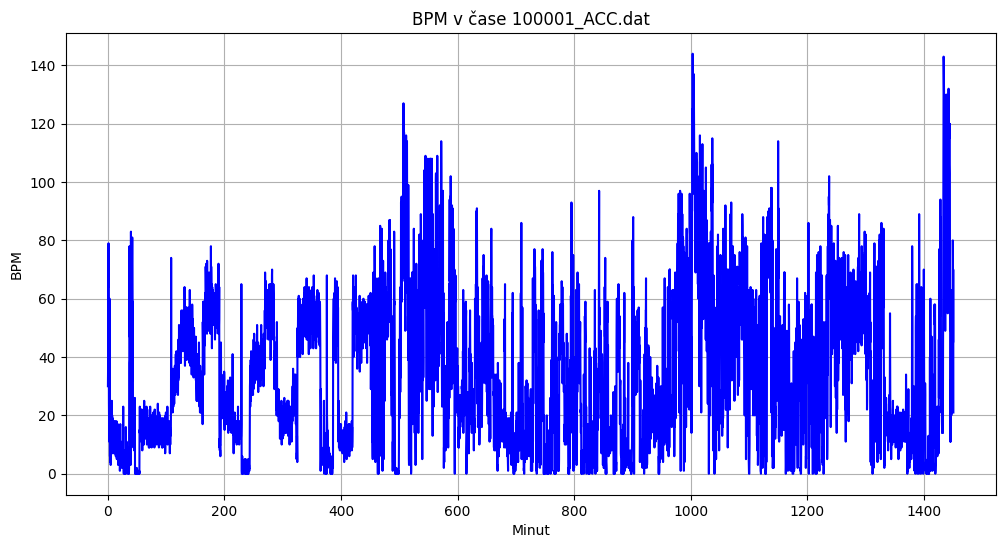

Zpracovávám soubor: 100001_ECG.dat


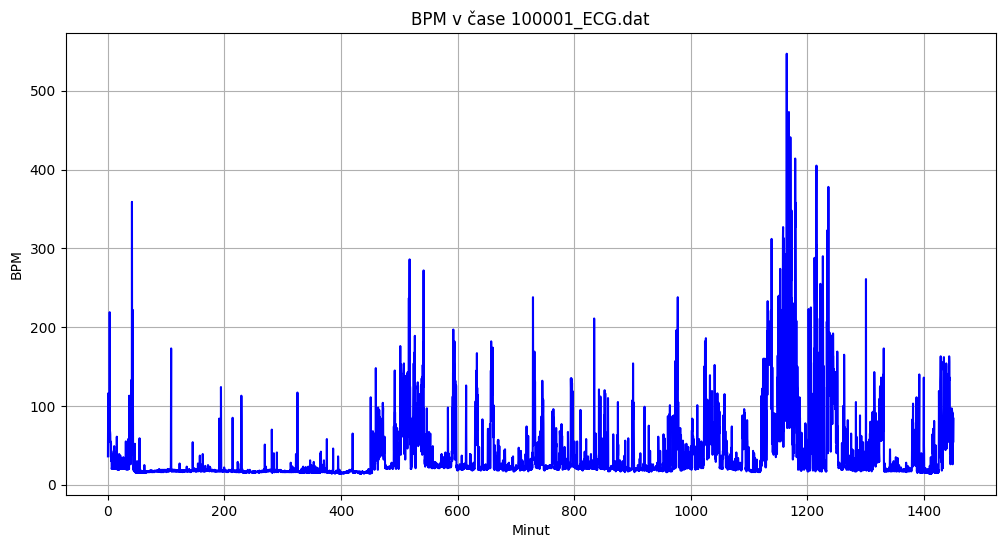

In [26]:
import wfdb
from wfdb import processing
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from scipy.fft import fft, ifft
import os
import pandas as pd

def load_data(path):
    """Načte soubor databáze a vrátí vzorky signálu EKG a seznam polí"""
    try:
        signals, fields = wfdb.rdsamp(path)
        ecg = signals[:, 0].flatten()
        ecg = high_pass_filter(ecg, fields["fs"])
        return ecg, fields
    except Exception as e:
        print(f"Chyba při načítání dat: {e}")
        return None, None

def estimate_threshold(signal, perc=95):
    return np.percentile(signal, perc)

def high_pass_filter(signal, samp_rate, cutoff_freq=50):
    tau = 1 / (2 * np.pi * cutoff_freq)
    alpha = tau / (tau + 1 / (2 * np.pi * samp_rate))
    y_prev = 0
    x_prev = 0

    filtered_signal = []
    for x in signal:
        y = alpha * (y_prev + x - x_prev)
        filtered_signal.append(y)
        y_prev = y
        x_prev = x

    return np.array(filtered_signal)

def remove_baseline_wander_fft(ekg_data, sampling_rate=4, cutoff_frequency=0.5):
    """Odebere baseline wander pro lepší manipulaci s daty pomocí Fourierovy transformace"""
    spectrum = fft(ekg_data)
    freq = np.fft.fftfreq(len(ekg_data), 1 / sampling_rate)
    spectrum[(freq > -cutoff_frequency) & (freq < cutoff_frequency)] = 0
    ekg_without_baseline = np.real(ifft(spectrum))
    return ekg_without_baseline

def find_Rpeaks(signal):
    """Najde R píky v EKG signálu"""
    threshold = estimate_threshold(signal)
    peaks = []
    is_peak = False
    current_peak_value = -np.inf
    current_peak_index = 0

    for i, value in enumerate(signal):
        if value > threshold:
            if not is_peak or value > current_peak_value:
                current_peak_value = value
                current_peak_index = i
            is_peak = True
        else:
            if is_peak:
                peaks.append(current_peak_index)
                is_peak = False
    return np.array(peaks)

def count_rpeaks_in_windows(signal, r_peaks, samp_rate):
    """Počítá počet R píků každých 15 sekund"""
    signal_duration = len(signal) / samp_rate
    window_duration = 15.0
    window_count = int(signal_duration / window_duration)

    r_peak_counts = [0] * window_count

    for r_peak in r_peaks:
        window_index = int(r_peak / (samp_rate * window_duration))
        if 0 <= window_index < window_count:
            r_peak_counts[window_index] += 1

    return r_peak_counts

def plot_bpm_over_time(bpm_values, driver, window_duration=15.0):
    """Graf BPM"""
    time_axis = [i * window_duration / 60.0 for i in range(len(bpm_values))]
    
    plt.figure(figsize=(12, 6))
    plt.plot(time_axis, bpm_values, linestyle='-', color='b')
    plt.title('BPM v čase ' + driver)
    plt.xlabel('Minut')
    plt.ylabel('BPM')
    plt.grid(True)
    plt.show()

def process_folder(folder_path):
    """Zpracuje všechny soubory ve složce"""
    files = [f for f in os.listdir(folder_path) if f.endswith('.dat')]
    
    for file in files:
        file_path = os.path.join(folder_path, file[:-4])  # Odebrání přípony .dat
        print(f"Zpracovávám soubor: {file}")
        
        ecg, fields = load_data(file_path)
        if ecg is None:
            continue
        
        r_peaks = find_Rpeaks(ecg)
        bpm_values = count_rpeaks_in_windows(ecg, r_peaks, fields["fs"])
        plot_bpm_over_time(bpm_values, file)

# Nastavte cestu ke složce s daty
folder_path = "brno-university-of-technology/100001"
process_folder(folder_path)


[       0      309      853 ... 87085769 87085904 87086757]


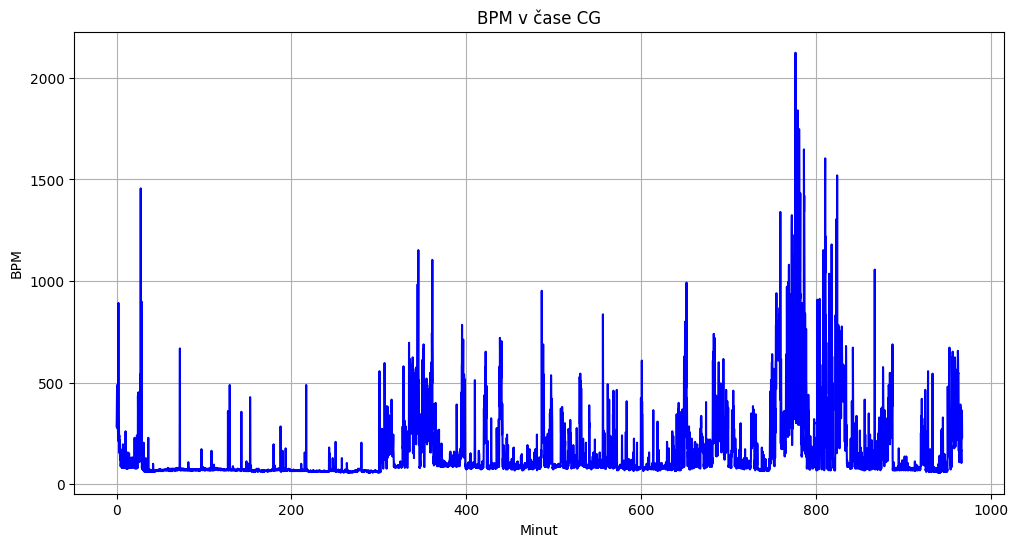

In [35]:
import wfdb
from wfdb import processing
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from scipy.fft import fft, ifft
import os 
import pandas as pd

def load_data(path):
    """Načte soubor databáze a vrátí vzorky signálu EKG a seznam polí"""
    try:
        signals, fields = wfdb.rdsamp(path)
        ecg = signals[:, 0].flatten()
        ecg = high_pass_filter(ecg, fields["fs"])
        return ecg, fields
    
    except Exception as e:
        print(f"Chyba při načítání dat: {e}")
        return None, None

def estimate_threshold(signal, perc=95):
    return np.percentile(signal, perc)

def high_pass_filter(signal, samp_rate, cutoff_freq=50):
    tau = 1 / (2 * np.pi * cutoff_freq)
    alpha = tau / (tau + 1 / (2 * np.pi * samp_rate))
    y_prev = 0
    x_prev = 0

    filtered_signal = []
    for x in signal:
        y = alpha * (y_prev + x - x_prev)
        filtered_signal.append(y)
        y_prev = y
        x_prev = x

    return np.array(filtered_signal)

def remove_baseline_wander_fft(ekg_data, sampling_rate=4, cutoff_frequency=0.5):
    """Odebere baseline wander pro lepší manipulaci s daty pomocí Fourierovy transformace
    k nalezení nízkofrekvenčních komponent a jejich odstranění."""
    spectrum = fft(ekg_data)
    freq = np.fft.fftfreq(len(ekg_data), 1 / sampling_rate)
    spectrum[(freq > -cutoff_frequency) & (freq < cutoff_frequency)] = 0
    ekg_without_baseline = np.real(ifft(spectrum))
    return ekg_without_baseline

def find_Rpeaks(signal):
    """Najde R píky v EKG signálu s dynamicky se měnící velikostí okna.
    Vrátí seznam píků a odpovídajících časů."""
    threshold = estimate_threshold(signal)
    peaks = []
    is_peak = False
    current_peak_value = -np.inf
    current_peak_index = 0

    for i, value in enumerate(signal):
        if value > threshold:
            if not is_peak or value > current_peak_value:
                current_peak_value = value
                current_peak_index = i
            is_peak = True
        else:
            if is_peak:
                peaks.append(current_peak_index)
                is_peak = False
    return np.array(peaks)

def count_rpeaks_in_windows(signal, r_peaks, samp_rate):
    """Počítá počet R píků každých 15 sekund"""
    signal_duration = len(signal) / samp_rate
    window_duration = 15.0
    window_count = int(signal_duration / window_duration)

    r_peak_counts = [0] * window_count

    for r_peak in r_peaks:
        window_index = int(r_peak / (samp_rate * window_duration))
        if 0 <= window_index < window_count:
            r_peak_counts[window_index] += 1

    return r_peak_counts

def plot_bpm_over_time(bpm_values, driver, window_duration=10.0):
    """Graf BPM"""
    time_axis = [i * window_duration / 60.0 for i in range(len(bpm_values))]
    
    plt.figure(figsize=(12, 6))
    plt.plot(time_axis, bpm_values, linestyle='-', color='b')
    plt.title('BPM v čase ' + driver)
    plt.xlabel('Minut')
    plt.ylabel('BPM')
    plt.grid(True)
    plt.show()
database = 'brno-university-of-technology/100001/100001_ECG' 
driver = database[-2:]
ECGnative, fields = load_data(database)
samp_rate = fields['fs']

ecg_data = np.array(ECGnative)
cutoff_frequency = 0.5

ecg_edit_fft = remove_baseline_wander_fft(ecg_data, samp_rate, cutoff_frequency=cutoff_frequency)
Rpeaks = find_Rpeaks(ecg_edit_fft)
print(Rpeaks)
r_peak_counts = [count* 4 for count in count_rpeaks_in_windows(ecg_edit_fft, Rpeaks, samp_rate)]

plot_bpm_over_time(r_peak_counts, driver)

Obsah složky brno-university-of-technology\103001: ['103001_ACC.dat', '103001_ACC.hea', '103001_ANN.csv', '103001_ECG.dat', '103001_ECG.hea']
Vzorkovací frekvence: 1000 Hz
Velikost signálu: 87125000 vzorků
Signál byl zkrácen na 6000000 vzorků.
Počet R-vrcholů: 10194
Průměrná tepová frekvence (BPM): 101.98


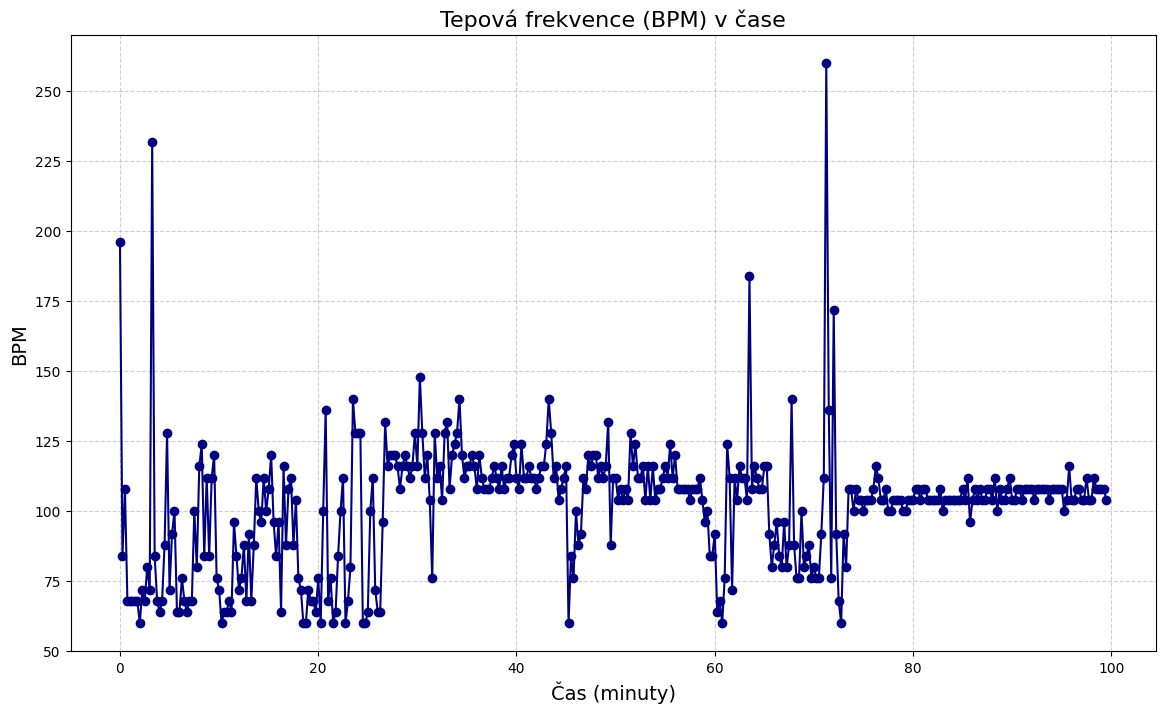

In [1]:
import wfdb
import numpy as np
from scipy.fft import fft, ifft
import matplotlib.pyplot as plt
import os


def zarovnat_signal(ecg_signal):
    """Zarovná EKG signál na osu X odečtením střední hodnoty."""
    return ecg_signal - np.mean(ecg_signal)


def odeber_baseline_wander(ecg_signal, vzorkovaci_frekvence, cutoff=0.5):
    """Odebere nízkofrekvenční složky pomocí Fourierovy transformace."""
    spektrum = fft(ecg_signal)
    frekvence = np.fft.fftfreq(len(ecg_signal), 1 / vzorkovaci_frekvence)
    spektrum[np.abs(frekvence) < cutoff] = 0
    return np.real(ifft(spektrum))


def najdi_r_peaky(ecg_signal, prah=95):
    """Najde R-vrcholky v EKG signálu."""
    threshold = np.percentile(ecg_signal, prah)
    r_peaky = []
    prochazejici = False
    for i, hodnota in enumerate(ecg_signal):
        if hodnota > threshold and not prochazejici:
            r_peaky.append(i)
            prochazejici = True
        elif hodnota < threshold:
            prochazejici = False
    return np.array(r_peaky)


def spocitej_bpm(r_peaky, vzorkovaci_frekvence, delka_okna=10):
    """Spočítá BPM (tepovou frekvenci) na základě R-vrcholů."""
    casove_intervaly = [r / vzorkovaci_frekvence for r in r_peaky]
    bpm_hodnoty = []
    pocet_oken = int(max(casove_intervaly) // delka_okna)

    for i in range(pocet_oken):
        zacatek = i * delka_okna
        konec = zacatek + delka_okna
        bpm = sum(zacatek <= t < konec for t in casove_intervaly) * (60 / delka_okna)
        bpm_hodnoty.append(bpm)

    return bpm_hodnoty


def vykresli_bpm(bpm_hodnoty, delka_okna=10):
    """Vykreslí graf BPM v čase."""
    casova_osa = [i * delka_okna / 60 for i in range(len(bpm_hodnoty))]
    plt.figure(figsize=(14, 8))
    plt.plot(casova_osa, bpm_hodnoty, linestyle='-', marker='o', color='navy')
    plt.title('Tepová frekvence (BPM) v čase', fontsize=16)
    plt.xlabel('Čas (minuty)', fontsize=14)
    plt.ylabel('BPM', fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()

    # Nastavení cesty k databázi
slozka_databaze = "brno-university-of-technology"
nazev_zaznamu = "103001"  # Může být např. "103001"
cesta_k_databazi = os.path.join(slozka_databaze, nazev_zaznamu)

# Zkontroluj obsah složky
soubory = os.listdir(cesta_k_databazi)
print(f"Obsah složky {cesta_k_databazi}: {soubory}")

# Najdi správný soubor pro EKG
nazev_ecg_souboru = None
for soubor in soubory:
    if soubor.endswith("_ECG.dat"):
        nazev_ecg_souboru = soubor[:-4]
        break

if nazev_ecg_souboru is None:
    raise FileNotFoundError(f"Ve složce {cesta_k_databazi} chybí správný soubor pro EKG!")

cesta_k_zaznamu = os.path.join(cesta_k_databazi, nazev_ecg_souboru)

# Načtení dat WFDB
zaznam = wfdb.rdrecord(cesta_k_zaznamu)
vzorkovaci_frekvence = zaznam.fs  # Vzorkovací frekvence
ekg_data = zaznam.p_signal[:, 0]  # Použití prvního kanálu

print(f"Vzorkovací frekvence: {vzorkovaci_frekvence} Hz")
print(f"Velikost signálu: {len(ekg_data)} vzorků")

# Pokud je signál příliš velký, použij jen část dat
max_vzorky = 6000000
if len(ekg_data) > max_vzorky:
    ekg_data = ekg_data[:max_vzorky]
    print(f"Signál byl zkrácen na {max_vzorky} vzorků.")

# Odstranění baseline wander
prahová_frekvence = 0.5
upraveny_signal = odeber_baseline_wander(ekg_data, vzorkovaci_frekvence, cutoff=prahová_frekvence)

# Detekce R-vrcholů
r_vrcholy = najdi_r_peaky(upraveny_signal)
print(f"Počet R-vrcholů: {len(r_vrcholy)}")

# Výpočet BPM (tepové frekvence) v časových oknech
bpm_hodnoty = spocitej_bpm(r_vrcholy, vzorkovaci_frekvence, delka_okna=15)

# Spočítání průměrného BPM
prumerne_bpm = np.mean(bpm_hodnoty)
print(f"Průměrná tepová frekvence (BPM): {prumerne_bpm:.2f}")

# Vykreslení BPM v čase
vykresli_bpm(bpm_hodnoty, delka_okna=15)



In [2]:
import os
import pandas as pd

def vyhodnotit_detekci(skutecne_vrcholy, detekovane_vrcholy, spravna_odchylka=0.0001):
    """
    Vyhodnotí detekci R-vrcholů porovnáním se skutečnými vrcholy.
    
    Parametry:
        skutecne_vrcholy (list): Skutečné vrcholy (referenční hodnoty).
        detekovane_vrcholy (list): Detekované vrcholy.
        spravna_odchylka (float): Maximální povolená odchylka mezi vrcholy, aby byly považovány za správně detekované.
    
    Návratové hodnoty:
        tuple: Počet správných detekcí, počet špatných detekcí, celkový počet vrcholů, počet detekovaných vrcholů.
    """
    spravne = 0
    celkem = len(skutecne_vrcholy)
    for skutecny_vrchol in skutecne_vrcholy:
        detekovano = False
        for detekovany_vrchol in detekovane_vrcholy:
            delta = (skutecny_vrchol + 1) / (detekovany_vrchol + 1)
            odchylka = np.abs(1 - delta)
            if odchylka < spravna_odchylka:
                detekovano = True
                break

        if detekovano:
            spravne += 1

    return spravne, celkem - spravne, celkem, len(detekovane_vrcholy)


def otestovat_soubor(cesta_k_souboru, zacatek=0, pocet_vzorku=100000, spravna_odchylka=0.0001):
    """
    Otestuje jeden soubor a vrátí výsledky detekce R-vrcholů.
    
    Parametry:
        cesta_k_souboru (str): Cesta k EKG souboru.
        zacatek (int): Počáteční index pro načítání dat.
        pocet_vzorku (int): Počet vzorků, které se mají načíst.
        spravna_odchylka (float): Maximální povolená odchylka mezi vrcholy.

    Návratové hodnoty:
        tuple: Výsledek vyhodnocení detekce.
    """
    # Zkontrolujte, zda soubor existuje
    if not os.path.exists(cesta_k_souboru + ".dat") or not os.path.exists(cesta_k_souboru + ".hea"):
        raise FileNotFoundError(f"Chybí soubor {cesta_k_souboru}.dat nebo {cesta_k_souboru}.hea")
    
    # Načtení signálu EKG
    signal, _ = wfdb.rdsamp(
        cesta_k_souboru, channels=None, sampfrom=zacatek, sampto=zacatek + pocet_vzorku
    )
    # Načtení skutečných R-vrcholů
    skutecne_vrcholy = wfdb.rdann(
        cesta_k_souboru, extension="atr", sampfrom=zacatek, sampto=zacatek + pocet_vzorku
    ).sample
    # První kanál signálu
    signal = signal[:, 0]
    # Detekce R-vrcholů
    detekovane_vrcholy = najdi_r_peaky(signal)
    # Vyhodnocení detekce
    return vyhodnotit_detekci(skutecne_vrcholy, detekovane_vrcholy, spravna_odchylka)


# Počítadla pro správné a celkové výsledky
pocet_spravnych = 0
celkovy_pocet = 0

# Seznam pro uložení dat
data = []

# Iterace přes všechny soubory ve složce
for soubor in os.listdir("mit-bih-normal/"):
    if not soubor.endswith(".dat"):
        continue

    # Odstranění přípony souboru
    nazev_souboru = soubor[:-4]
    
    # Správné sestavení cesty k souboru
    cesta_k_souboru = os.path.join("mit-bih-normal", nazev_souboru)
    
    # Zpracování souboru pomocí funkce otestovat_soubor
    try:
        spravne, spatne, celkem, r_peaky = otestovat_soubor(cesta_k_souboru)
        pocet_spravnych += spravne
        celkovy_pocet += celkem

        # Výpočet úspěšnosti pro aktuální soubor
        uspesnost = spravne / celkem * 100 if celkem > 0 else 0
        stav = "Zpracováno úspěšně"

    except FileNotFoundError as e:
        print(f"Chyba: Soubor {cesta_k_souboru} nebyl nalezen. {e}")
        spravne, spatne, celkem, uspesnost, stav = 0, 0, 0, 0, "Chybí soubor"

    except Exception as e:
        print(f"Nastala neočekávaná chyba při zpracování souboru {cesta_k_souboru}: {e}")
        spravne, spatne, celkem, uspesnost, stav = 0, 0, 0, 0, "Chyba při zpracování"

    # Přidání dat do seznamu
    data.append([nazev_souboru, spravne, spatne, celkem, uspesnost, stav])

# Vytvoření DataFrame z dat
df = pd.DataFrame(data, columns=["Soubor", "Správně", "Špatně", "Celkem", "Úspěšnost (%)", "Stav"])

# Výpočet celkové úspěšnosti
celkova_uspesnost = pocet_spravnych / celkovy_pocet * 100 if celkovy_pocet > 0 else 0

# Uložení výsledků do CSV souboru
vystupni_csv = "vysledky_testu.csv"
df.to_csv(vystupni_csv, index=False, encoding='utf-8')

print("Výsledky byly úspěšně uloženy do CSV souboru.")
print(f"Celková úspěšnost: {celkova_uspesnost:.2f}%")
print(f"Soubor byl uložen jako: {vystupni_csv}")


Výsledky byly úspěšně uloženy do CSV souboru.
Celková úspěšnost: 86.98%
Soubor byl uložen jako: vysledky_testu.csv
